In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# t Confidence intervals

## Small sample confidence intervals

In the previous lecture, we discussed creating a confidence interval using the CLT. Our intervals took the form:

$$
Est \pm Z \times SE_{Est}.
$$

In this lecture, we discuss some methods for small samples, notably ***Gosset’s t distribution*** and ***t confidence intervals***.

These intervals are of the form:

$$
Est \pm t \times SE_{Est}.
$$

So the only change is that we’ve replaced the $Z$ quantile now with a $t$ quantile. These are some of the handiest of intervals in all of statistics. If you want a rule between whether to use a $t$ interval or normal interval, just always use the $t$ interval.

## Gosset's *t* distribution

The $t$ distribution was invented by William Gosset (under the pseudonym “Student”) in 1908. Fisher provided further mathematical details about the distribution later. This distribution has thicker tails than the normal. It’s indexed by a degrees of freedom and it gets more like a standard normal as the degrees of freedom get larger. It assumes that the underlying data are iid Gaussian with the result that

$$
\frac{\bar{X} - \mu}{S/ \sqrt{n}}
$$

follows Gosset's distribution with $n-1$ degrees of freedom. (If we replace $S$ by $\sigma$ the statistic would be exactly standard normal). The interval is:

$$
\bar{X} \pm t_{n-1}S / \sqrt{n}
$$

where $t_{n-1}$ is the relevant quantile for the $t$ distribution.



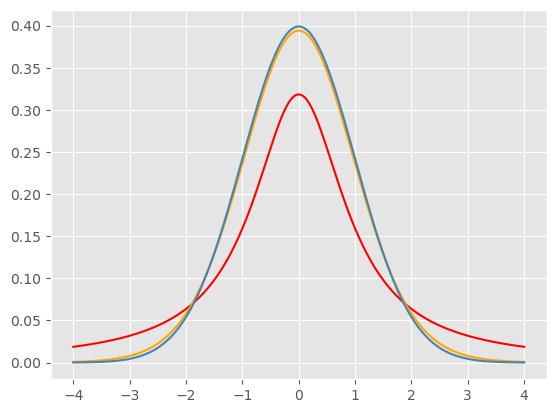

In [2]:
from scipy.stats import t
from scipy.stats import norm

x = np.linspace(-4,4,1000)


y_1 = t.pdf(x, df = 1)
sns.lineplot(
    x = x,
    y = y_1,
    color = 'red'
)

y_20 = t.pdf(x, df = 20)
sns.lineplot(
    x = x,
    y = y_20,
    color = 'orange'
)

y_norm = norm.pdf(x)
sns.lineplot(
    x = x,
    y = y_norm,
    color = 'steelblue'
);

In [3]:
norm.ppf(0.5)

0.0

In [4]:
t.ppf(0.5, df = 5)

6.976003101422384e-17

<Axes: >

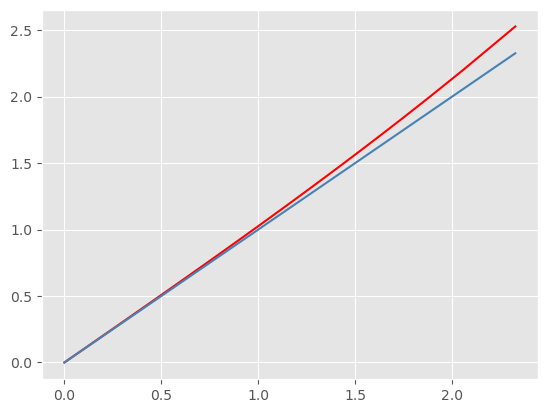

In [5]:
x = np.arange(0.5, 1.0, 0.01)

df = 20
y_t = t.ppf(x, df = df)
y_n = norm.ppf(x)

sns.lineplot(
    x = y_n,
    y = y_t,
    color = 'red'
)

sns.lineplot(
    x = y_n,
    y = y_n,
    color = 'steelblue'
)

# sns.lineplot(
#     x = x,
#     y = y_n,
#     color = 'steelblue'
# )

### Summay notes

In this section, we give an overview of important facts about the $t$ distribution.

- The $t$ interval technically assumes that the data are iid normal, though it is robust to this assumption.
- It works well whenever the distribution of the data is roughly symmetric and mound shaped.
- Paired observations are often analyzed using the t interval by taking differences.
- For large degrees of freedom, $t$ quantiles become the same as standard normal quantiles; therefore this interval converges to the same interval as the CLT yielded.
- For skewed distributions, the spirit of the $t$ interval assumptions are violated.
    - Also, for skewed distributions, it doesn’t make a lot of sense to center the interval at the mean.
    - In this case, consider taking logs or using a different summary like the median.
- For highly discrete data, like binary, other intervals are available.

## Example of the $t$ interval, Goesset's sleep data 

In R typing r data(sleep) brings up the sleep data originally analyzed in Gosset’s Biometrika paper, which shows the increase in hours for 10 patients on two soporific drugs. R treats the data as two groups rather than paired.

### The data

Here’s a plot of the data. In this plot paired observations are connected with a line.

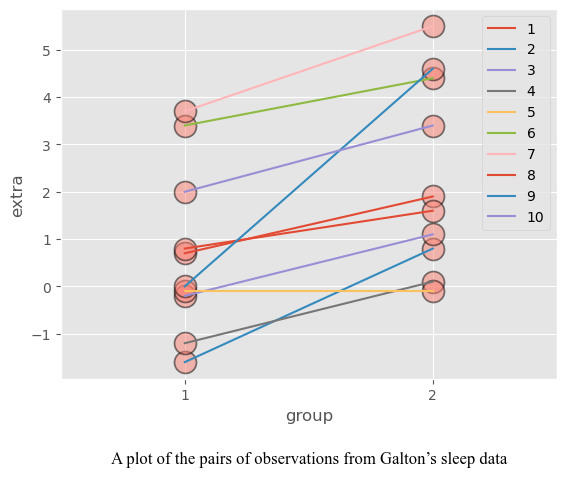

In [6]:
sleep = pd.read_csv('./data/sleep.csv')

sns.scatterplot(
    data = sleep,
    x = 'group',
    y = 'extra', 
    s = 250,
    color = 'salmon',
    alpha = 0.5,
    edgecolor = 'k'
);


for id in np.arange(sleep['ID'].min(), sleep['ID'].max()+1):
    plt.plot([1, 2],
             [sleep[(sleep['ID']==id) & (sleep['group']==1)]['extra'].values[0], sleep[(sleep['ID']==id) & (sleep['group']==2)]['extra'].values[0]],
            label = str(id));

plt.legend(loc = 'upper right')

plt.xlim(0.5, 2.5)
plt.xticks([1,2]);

csfont = {'fontname':'Times New Roman'}
plt.title('A plot of the pairs of observations from Galton’s sleep data', y=-0.25, fontsize = 12, **csfont);

Now let’s calculate the t interval for the differences from baseline to follow up. Below we give three different ways in Python for calculating the interval.

In [7]:
diff = sleep[sleep['group'] == 2].set_index('ID')['extra'] - sleep[sleep['group'] == 1].set_index('ID')['extra']
se = diff.std()/np.sqrt(diff.shape[0])

diff.mean() + np.array([-1,1])*t.ppf(0.975, df = diff.shape[0] - 1)*se

array([0.70011424, 2.45988576])

In [8]:
from scipy.stats import sem

t.interval(confidence=0.95, df=diff.shape[0]-1, loc=np.mean(diff), scale=sem(diff))

(0.700114236701277, 2.459885763298723)

In [9]:
from scipy.stats import ttest_rel
k = ttest_rel(sleep[sleep['group'] == 2].set_index('ID')['extra'], sleep[sleep['group'] == 1].set_index('ID')['extra'])

print(str(k.confidence_interval().low) + ", " + str(k.confidence_interval().high))

0.7001142367012769, 2.459885763298723


Therefore, since our interval doesn’t include 0, our 95% confidence interval estimate for the mean change (follow up - baseline) is 0.70 to 2.45.

## Independent group *t* confidence intervals

Suppose that we want to compare the mean blood pressure between two groups in a randomized trial; those who received the treatment to those who received a placebo. The randomization is useful for attempting to balance unobserved covariates that might contaminate our results. Because of the randomization, it would be reasonable to compare the two groups without considering further variables.

We cannot use the paired $t$ interval that we just used for Galton’s data, because the groups are independent. Person 1 from the treated group has no relationship with person 1 from the control group. Moreover, the groups may have different sample sizes, so taking paired differences may not even be possible even if it isn’t advisable in this setting.

We now present methods for creating confidence intervals for comparing independent groups.

### Confidence interval

A $(1 - \alpha) \times 100 \%$ confidence interval for the mean difference between the groups, $\mu_{y} - \mu_{x}$ is:

$$
\bar{Y} - \bar{X} \pm t_{n_{x} + n_{y}-2,1-\alpha/2}S_{p} \left(\frac{1}{n_{x}} + \frac{1}{n_{y}} \right)
$$

The notation $t_{n_{x} + n_{y}-2,1-\alpha_{2}}$ means a $t$ quantile with $n_{x} + n_{y} − 2$ degrees of freedom. The pooled variance estimator is:

$$
S^{2}_{p} = \{(n_{x} -1)S^{2}_{x} + (n_{y} -1)S^{2}_{y}\}/(n_{x} + n_{y} -2)
$$

This variance estimate is used if one is willing to assume a constant variance across the groups. It is a weighted average of the group-specific variances, with greater weight given to whichever group has the larger sample size.

If there is some doubt about the constant variance assumption, assume a different variance per group, which we will discuss later.

## Mistakenly treating the sleep data as grouped

Let’s first go through an example where we treat paired data as if it were independent. Consider Galton’s sleep data from before. In the code below, we do the Python code for grouped data directly, and using the `scipy.stat` `ttest.ind` function.

In [10]:
g1 = sleep[sleep['group']==1].set_index('ID')['extra']

In [11]:
g2 = sleep[sleep['group']==2].set_index('ID')['extra']

In [12]:
from scipy.stats import ttest_rel, ttest_ind

print("Confidence paired interval - dependent: ({}, {})".format(ttest_rel(g2, g1).confidence_interval().low, 
                                                                         ttest_rel(g2, g1).confidence_interval().high))
print("Confidence grouped interval - independent: ({}, {})".format(ttest_ind(g2, g1, equal_var=True).confidence_interval().low,
                                                                           ttest_ind(g2, g1, equal_var=True).confidence_interval().high))

Confidence paired interval - dependent: (0.7001142367012769, 2.459885763298723)
Confidence grouped interval - independent: (-0.20387403228753276, 3.363874032287532)


Notice that the paired interval is entirely above zero. The grouped interval contains zero. Thus, acknowledging the pairing explains variation that would otherwise be absorbed into the variation for the group means. As a result, treating the groups as independent results in wider intervals. Even if it didn’t result in a shorter interval, the paired interval would be correct as the groups are not statistically independent!

In [13]:
(g2-g1).mean() + np.array([-1,1]) * t.ppf(0.975, df=len(g1)-1) * sem((g2-g1))

array([0.70011424, 2.45988576])

In [14]:
# pooled variance estimator
sp2 = ((len(g1)-1) * g1.std()**2 + (len(g2)-1) * g2.std()**2)/(len(g1) + len(g2) -2)
sp = np.sqrt(sp2)

(g2-g1).mean() + np.array([-1,1]) * t.ppf(0.975, df=len(g1) + len(g2)-2)*  sp*np.sqrt((1/len(g1) + 1/len(g2)))

array([-0.20387403,  3.36387403])

## `ChickWeight` data in Python

In [15]:
ChickenWeigh = pd.read_csv('./data/ChickWeight.csv')
print(ChickenWeigh.shape)
ChickenWeigh.head()

(578, 4)


,weight,Time,Chick,Diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1


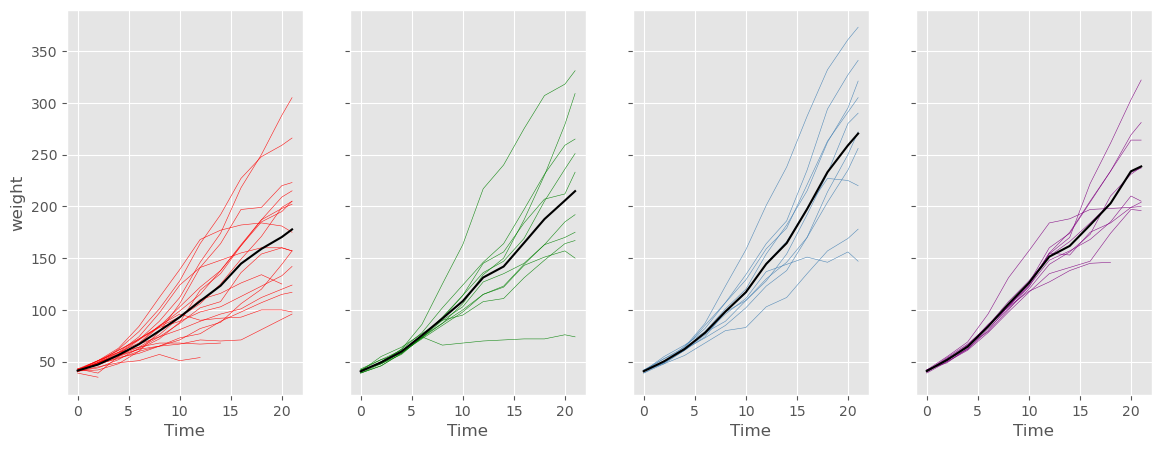

In [16]:
figsize=(14,5)

fig, (axs1, axs2, axs3, axs4) = plt.subplots(ncols=4, sharey=True, sharex = True, figsize=figsize)

palette = sns.color_palette(['red'], len(ChickenWeigh['Chick'].unique()))

sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 1],
    x = 'Time',
    y = 'weight',
    hue = 'Chick',
    palette=palette, 
    linewidth = 0.4,
    alpha = 0.9,    
    legend=False,
    ax = axs1
);

sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 1],
    x = 'Time',
    y = 'weight',
    color = 'black', 
    ci=None,
    legend=False,
    ax = axs1
);

palette = sns.color_palette(['green'], len(ChickenWeigh['Chick'].unique()))
sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 2],
    x = 'Time',
    y = 'weight',
    hue = 'Chick',
    palette=palette,
    linewidth = 0.4,
    alpha = 0.9,
    legend=False,
    ax = axs2
);

sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 2],
    x = 'Time',
    y = 'weight',
    color = 'black', 
    ci=None,
    legend=False,
    ax = axs2
);

palette = sns.color_palette(['steelblue'], len(ChickenWeigh['Chick'].unique()))
sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 3],
    x = 'Time',
    y = 'weight',
    hue = 'Chick',
    palette=palette,
    linewidth = 0.4,
    alpha = 0.9,
    legend=False,
    ax = axs3
);

sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 3],
    x = 'Time',
    y = 'weight',
    color = 'black', 
    ci=None,
    legend=False,
    ax = axs3
);


palette = sns.color_palette(['purple'], len(ChickenWeigh['Chick'].unique()))
sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 4],
    x = 'Time',
    y = 'weight',
    hue = 'Chick',
    palette=palette,
    linewidth = 0.4,
    alpha = 0.9,
    legend=False,
    ax = axs4
);

sns.lineplot(
    data = ChickenWeigh[ChickenWeigh['Diet'] == 4],
    x = 'Time',
    y = 'weight',
    color = 'black', 
    ci=None,
    legend=False,
    ax = axs4
);


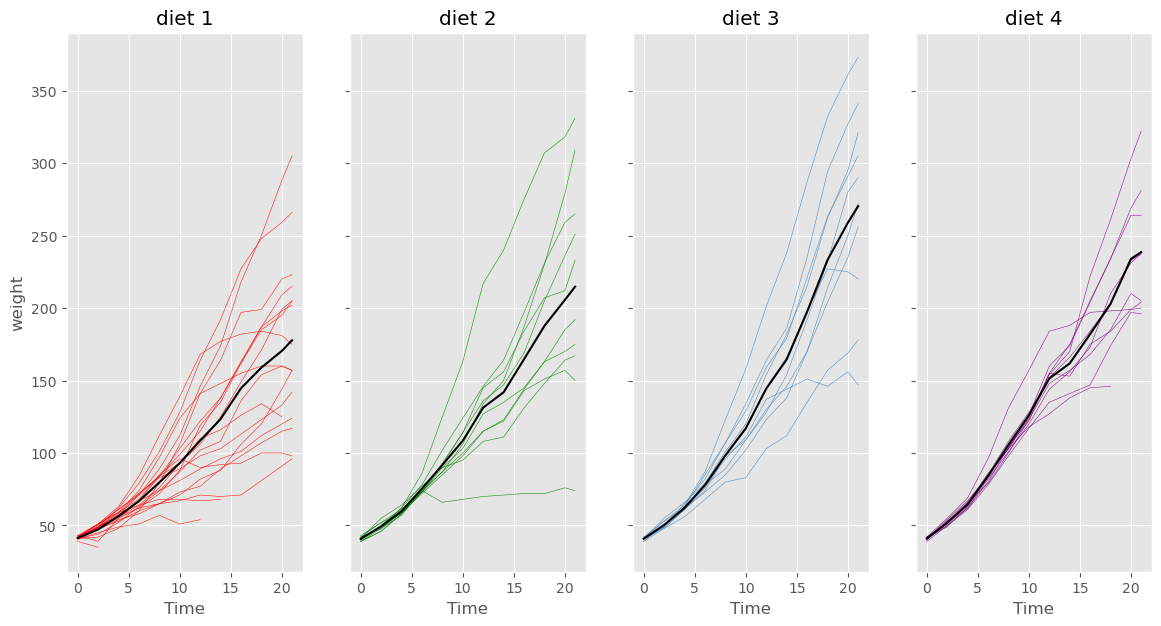

In [17]:
figsize=(14,7)
fig, axs = plt.subplots(ncols=4, sharey=True, sharex = True, figsize=figsize)

palettes = ['red', 'green', 'steelblue', 'purple']

for i in np.sort(ChickenWeigh['Diet'].unique()):
    palette = sns.color_palette([palettes[i-1]], len(ChickenWeigh['Chick'].unique()))
    sns.lineplot(
        data = ChickenWeigh[ChickenWeigh['Diet'] == i],
        x = 'Time',
        y = 'weight',
        hue = 'Chick',
        palette=palette,
        linewidth = 0.4,
        alpha = 0.9,
        legend=False,
        ax = axs[i-1],
        label = str(i)
    ).set_title('diet {}'.format(str(i)));

    sns.lineplot(
        data = ChickenWeigh[ChickenWeigh['Diet'] == i],
        x = 'Time',
        y = 'weight',
        color = 'black', 
        ci=None,
        legend=False,
        ax = axs[i-1]
    );

plt.xlabel('Time');

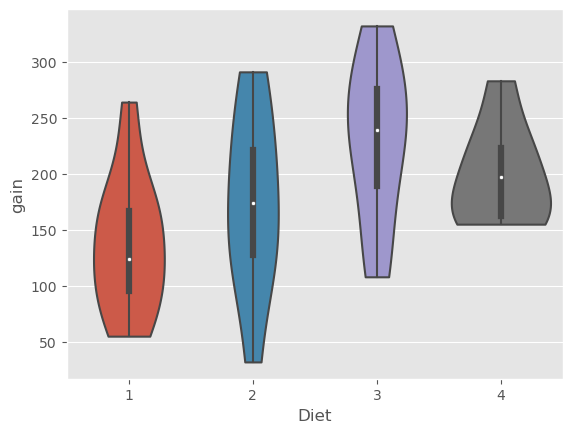

In [18]:
wideCW = pd.read_csv('./data/wideCW.csv')
sns.violinplot(
    data = wideCW,
    x = 'Diet',
    y = 'gain',
    cut=0.
);

Now let’s do a $t$ interval comparing groups 1 and 4. We’ll show the two intervals, one assuming that the variances are equal and one assuming otherwise.

In [19]:
d1 = wideCW[wideCW['Diet'] == 1]['gain']
d2 = wideCW[wideCW['Diet'] == 4]['gain']

In [20]:
print(np.round(ttest_ind(d1.dropna(), d2.dropna(), equal_var=True).confidence_interval(), 2))
print(np.round(ttest_ind(d1.dropna(), d2.dropna(), equal_var=False).confidence_interval(), 2))

[-108.15  -14.81]
[-104.66  -18.3 ]


For the time being, let’s interpret the equal variance interval. Since the interval is entirely below zero it suggest that group 1 had less weight gain than group 4 (at $95\%$ confidence).

## Unequal variances

Under unequal variances our $t$ interval becomes:

$$
\bar{Y} - \bar{X} \pm t_{df} \times \left( \frac{s^{2}_{x}}{n_{x}} + \frac{s^{2}_{y}}{n_{y}} \right)^{1/2}
$$

where $t_{df}$ is the $t$ quantile calculated with degrees of freedom:

$$
df = \frac{(S^{2}_{x}/n_{x} + S^{2}_{y}/n_{y})}{\left(\frac{S^{2}_{x}}{n_{x}}\right)^{2}/(n_{x}-1) + \left(\frac{S^{2}_{y}}{n_{y}}\right)^{2}/(n_{y}-1)}
$$

which will be approximately a $95\%$ interval. This works really well. So when in doubt, just assume unequal variances. Also, we present the formula for completeness. In practice, it’s easy to mess up, so make sure to use the appropriate `scipy.stats` Python functions.

Referring back to the previous `ChickWeight` example, the violin plots suggest that considering unequal variances would be wise. Recall the code is

In [21]:
np.round(ttest_ind(d1.dropna(), d2.dropna(), equal_var=False).confidence_interval(), 2)

array([-104.66,  -18.3 ])

This interval is remains entirely below zero. However, it is wider than the equal variance interval.

## Summary notes

- The $t$ distribution is useful for small sample size comparison
- It technically assumes normality, but is robust to this assumption within limits
- The $t$ distribution gives rises to $t$ confidence intervals (and tests, which we will see later)

For other kinds of data, there are preferable small and large sample intervals and tests.

- For binomial data, there's lot of ways to compare two groups.
    - Relative risk, risk difference, odds ratio.
    - Chi-squared tests, normal approximations, exact tests.
- For count data, there's also Chi-squared tests and exact tests.

In [22]:
diff.mean() + np.array([-1,1])*norm.ppf(0.975)*se

array([0.81765491, 2.34234509])

In [23]:
diff.mean() + np.array([-1,1])*t.ppf(0.975, df = diff.shape[0] - 1)*se

array([0.70011424, 2.45988576])

In [24]:
from scipy.stats import ttest_rel
k = ttest_rel(sleep[sleep['group'] == 2].set_index('ID')['extra'], sleep[sleep['group'] == 1].set_index('ID')['extra'])

k.confidence_interval()

ConfidenceInterval(low=0.7001142367012769, high=2.459885763298723)

In [25]:
from scipy.stats import ttest_ind
k = ttest_ind(sleep[sleep['group'] == 2].set_index('ID')['extra'], 
              sleep[sleep['group'] == 1].set_index('ID')['extra'],
             equal_var=False)

In [26]:
k.confidence_interval()

ConfidenceInterval(low=-0.20548323071163632, high=3.365483230711636)

In [27]:
for id in np.arange(sleep['ID'].min(), sleep['ID'].max()+1):
    print(id)

1
2
3
4
5
6
7
8
9
10


In [28]:
# [1, sleep[(sleep['ID']==1) & (sleep['group']==1)]['extra'].values[0]],
[2, sleep[(sleep['ID']==1) & (sleep['group']==2)]['extra'].values[0]]

[2, 1.9]

In [29]:
[1, sleep[(sleep['ID']==1) & (sleep['group']==1)]['extra'].values[0]]

[1, 0.7]

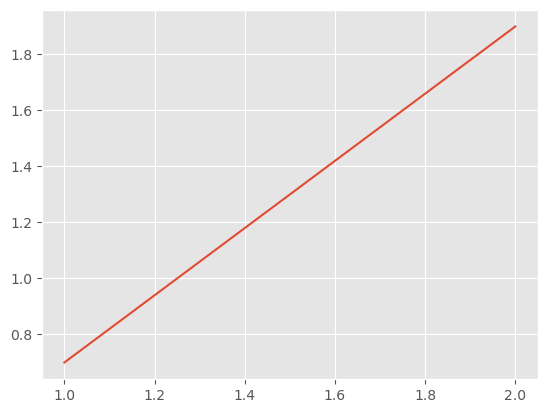

In [30]:
plt.plot([1, 2], 
         [sleep[(sleep['ID']==1) & (sleep['group']==1)]['extra'].values[0], sleep[(sleep['ID']==1) & (sleep['group']==2)]['extra'].values[0]]);

In [31]:
sleep[(sleep['ID']==1) & (sleep['group']==1)]['extra']

0    0.7
Name: extra, dtype: float64

In [32]:
sleep.head()

,extra,group,ID
0,0.7,1,1
1,-1.6,1,2
2,-0.2,1,3
3,-1.2,1,4
4,-0.1,1,5
